Jupyter Notebook for coauthorship network of scientists working on network theory and experiment

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz
from copy import deepcopy
import json
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import os

/Users/ashfak/venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Import  Network and feature matrix creation

In [2]:
# Create the graph (example using networkx)
G = nx.read_gml('netscience.gml')  # Load the Dolphin network if available or replace with appropriate graph loading method
node_names = np.array(list(G.nodes()))
print(node_names)
# Adjacency matrix
A = nx.adjacency_matrix(G).toarray()

# Adding self-loops
A = A + np.eye(G.number_of_nodes())

# Degree matrix
D = np.diag(np.sum(A, axis=1))

# Compute D^-0.5
D_half_norm = fractional_matrix_power(D, -0.5)

# Feature matrix initialization (simple identity matrix in this example)
E = np.eye(G.number_of_nodes())
C = np.eye(G.number_of_nodes())  # This is just a placeholder, replace or modify as per actual features
X = np.concatenate((E, C), axis=1)

# Graph convolution operation
X = D_half_norm.dot(A).dot(D_half_norm).dot(X)

['ABRAMSON, G' 'KUPERMAN, M' 'ACEBRON, J' ... 'HUANG, Z' 'ZHU, J'
 'ZIMMERMANN, M']


Define the variational autoencoder

In [3]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, A, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.A = A
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.architecture_loss_tracker = keras.metrics.Mean(
            name="architecture_loss"
        )

    def call(self, inputs):
      mean, log_var, x = self.encoder(inputs)
      x = self.decoder(x)
      return x

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.architecture_loss_tracker
        ]
    def predict(self, data):
       z_mean, z_log_var, z = self.encoder(data)
       output = self.decoder(z)
       return output

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
            #    )
            #)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data-reconstruction), axis=(1)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            architecture_loss = tf.reduce_mean(tf.square(self.A - tf.matmul(z,z,transpose_b=True)))
            total_loss = reconstruction_loss + kl_loss + architecture_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.architecture_loss_tracker.update_state(architecture_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "architecture_loss": self.architecture_loss_tracker.result()
        }

Define hyperparameters

In [4]:
nFeatures = X.shape[1]
nEmbeddings = 2
nEpochs = 8000
learningRate = 0.001
optimizer = Adam(learningRate)
batchSize = X.shape[0]

2024-04-21 02:30:51.882605: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-21 02:30:51.882701: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-21 02:30:51.882724: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-21 02:30:51.882769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-21 02:30:51.882793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Process feature matrix

In [5]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

Define VAE's architecture

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

print(nFeatures)
input_encoder = Input(shape=(nFeatures, ))
nNeurons = nFeatures // 2
x = Dense(nNeurons, activation='tanh')(input_encoder)
nNeurons = nNeurons // 2
while(nNeurons >= nEmbeddings * 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons // 2
z_mean = Dense(nEmbeddings, name="z_mean")(x)
z_log_var = Dense(nEmbeddings, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

input_decoder = Input(shape=(nEmbeddings, ))
nNeurons = nEmbeddings * 2
x = Dense(nNeurons, activation='tanh')(input_decoder)
nNeurons = nNeurons * 2
while(nNeurons <= nFeatures // 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons * 2
recon = Dense(nFeatures)(x)
encoder = Model(input_encoder, [z_mean, z_log_var, z], name="encoder")
decoder = Model(input_decoder, recon, name="decoder")
vae = VAE(encoder, decoder, A)
vae.compile(optimizer=optimizer)
vae.built = True

3178


In [7]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3178)           │     3,257,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,958,542 (15.10 MB)

 Trainable params: 3,958,542 (15.10 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
vae.encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3178)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1589)      │  5,051,431 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 794)       │  1,262,460 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 397)       │    315,615 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 198)       │     78,804 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 99)        │     19,701 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 49)        │      4,900 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 24)        │      1,200 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 12)        │        300 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 6)         │         78 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         14 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         14 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,734,517 (25.69 MB)

 Trainable params: 6,734,517 (25.69 MB)

 Non-trainable params: 0 (0.00 B)

Train VAE

In [9]:
hist = vae.fit(X, epochs = nEpochs, batch_size=batchSize, verbose =False)

2024-04-21 02:31:28.720665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [10]:
vae.save_weights(os.getcwd()+'/vae_coauthors' + '.weights.h5')
vae.load_weights(os.getcwd()+'/vae_coauthors' + '.weights.h5')

dict_keys(['architecture_loss', 'kl_loss', 'reconstruction_loss', 'total_loss'])


Text(0, 0.5, 'Architecture loss')

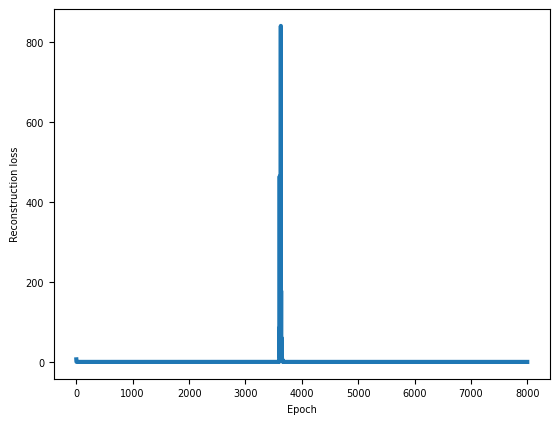

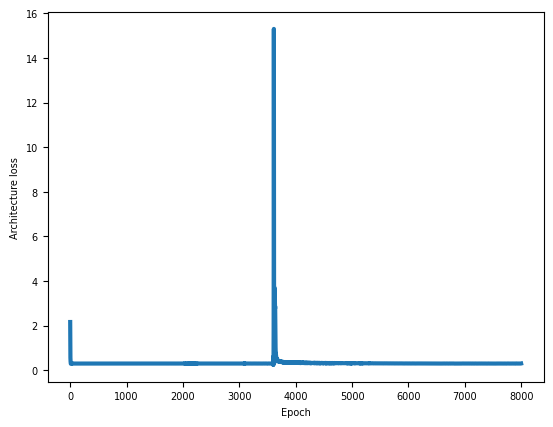

In [31]:
print(hist.history.keys())
x_range = range(len(hist.history['total_loss']))
plt.plot(x_range, hist.history['reconstruction_loss'])
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
plt.figure()
plt.plot(x_range, hist.history['architecture_loss'])
plt.xlabel('Epoch')
plt.ylabel('Architecture loss')

In [12]:
_,_,Z = vae.encoder(X)

Apply c-means

In [13]:
maxNCenters = 100
m = 10
losses = []
memberships = []
centroids = []
for nCenters in range(2,maxNCenters+1):
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
          Z.numpy().T, nCenters, m, error=0.005, maxiter=1000, init=None)
  memberships.append(u)
  centroids.append(cntr)
  sse = 0
  for i in range(len(Z)):
    zLoc = np.asarray(Z[i])
    for j in range(nCenters):
      cLoc = np.asarray(cntr[j])
      sse += u[j][i] * np.sum(np.square(zLoc - cLoc))
  losses.append(sse)
  #losses.append(np.mean(np.square(d)))
with open(os.getcwd() + '/memberships_coauthor/' + f'_m={m}.pkl','wb') as f:
  pickle.dump([memberships, centroids], f)

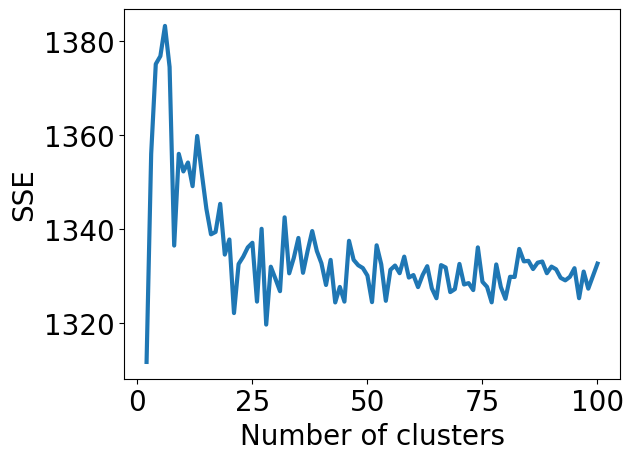

In [14]:
x_range = [i for i in range(2,maxNCenters+1)]
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,losses)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.savefig(os.getcwd() + '/figures_coauthor/'+ f'_sse_cmeans_m={m}.png', dpi=450, bbox_inches = "tight")

In [15]:
n_clusters = 20
members = [[] for i in range(n_clusters)]
members_classes = [[] for i in range(n_clusters)]
clusters = np.argmax(memberships[n_clusters-2].T, axis = 1)
print(node_names)
node_names_array = np.array(node_names)
for i in range(len(clusters)):
  members[clusters[i]].append(i)
  members_classes[clusters[i]].append(node_names[i])

['ABRAMSON, G' 'KUPERMAN, M' 'ACEBRON, J' ... 'HUANG, Z' 'ZHU, J'
 'ZIMMERMANN, M']


In [16]:
file = open(os.getcwd()  + '/list_clusters_coauthor/'+'_'+ str(n_clusters) + f'_no_redundancy_m={m}.json','w')
file.write(json.dumps(members_classes))
file.close()

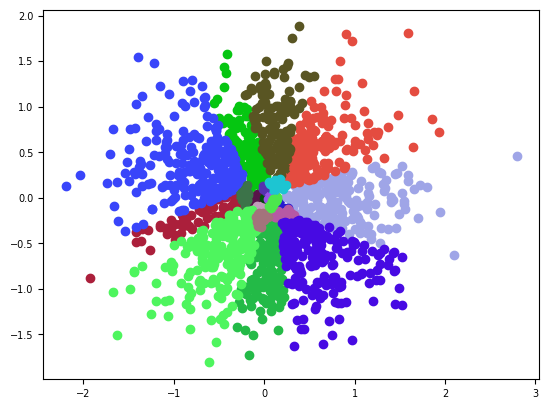

In [17]:
import random
y = [[] for i in range(n_clusters)]
x = [[] for i in range(n_clusters)]
centroid_y = []
centroid_x = []
hexadecimal_alphabets = '0123456789ABCDEF'
colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n_clusters)]
# colors = ['red','green','blue','purple','orange', 'black', 'gray', 'pink', 'yellow', 'navy']
for i in range(n_clusters):
  for j in members[i]:
    y[i].append(Z[j][1])
    x[i].append(Z[j][0])
  centroid_y.append(centroids[n_clusters-2][i][1])
  centroid_x.append(centroids[n_clusters-2][i][0])
# plt.axis('off')
plt.rcParams.update({'font.size': 7, 'lines.linewidth':3})
for i in range(n_clusters):
  plt.scatter([centroid_x[i]], [centroid_y[i]], color=colors[i],marker='x')
  plt.scatter(x[i], y[i], color=colors[i])
  # for j in range(len(x[i])):
  #   plt.text(x[i][j], y[i][j], members_classes[i][j])
plt.savefig(os.getcwd() +'/figures_coauthor/'+ '_' + str(n_clusters) + f'_scatter_no_redundancy_m={m}.pdf', dpi=450, bbox_inches = "tight")

In [18]:
thresholds = []
i = 0.1
while(i <= 0.5):
  thresholds.append(round(i,2))
  i += 0.05
set_members = []
for threshold in thresholds:
  tmp_members = deepcopy(members)
  tmp_members_classes = deepcopy(members_classes)
  for inx, membership in enumerate(memberships[n_clusters-2]):
    for inx2, score in enumerate(membership):
      if(score >=  threshold and inx2 not in tmp_members[inx]):
        tmp_members[inx].append(inx2)
        tmp_members_classes[inx].append(node_names_array[inx2])
  set_members.append(tmp_members_classes)
  file = open(os.getcwd() + '/list_clusters_coauthor/'+'_' + str(n_clusters) + f'_redundancy_m={m}_' + str(threshold) + '.json','w')
  file.write(json.dumps(tmp_members_classes))
  file.close()

In [19]:
for lst in set_members[4]:
  print(len(lst))

13
194
165
5
140
11
4
113
12
75
17
237
13
202
5
15
139
201
10
18


In [20]:
for member in members:
  print(len(member))

13
194
165
5
140
11
4
113
12
75
17
237
13
202
5
15
139
201
10
18


In [21]:
print(memberships[0][0])

[0.51108836 0.51470318 0.47609381 ... 0.50618423 0.48683313 0.51869043]


In [23]:
# Path to your JSON file
file_path = os.getcwd() + '/list_clusters_coauthor/' + '_20_redundancy_m=10_0.1.json'

# Load the JSON data from the file
with open(file_path, 'r') as file:
    data = json.load(file)

# Dictionary to count occurrences of each name
name_counts = {}

# Loop through each list in the data
for name_list in data:
    for name in name_list:
        if name in name_counts:
            name_counts[name] += 1
        else:
            name_counts[name] = 1

# Find and print duplicate names
duplicates = {name: count for name, count in name_counts.items() if count > 1}
print("Duplicate Names and their counts:")
for name, count in duplicates.items():
    print(f"{name}: {count}")

# Optional: Print total number of unique names
print("Total unique names:", len(name_counts))

Duplicate Names and their counts:
Total unique names: 1589


In [27]:
graph = nx.read_gml('netscience.gml')

# Specify the label of the node you're interested in
target_node_name = 'CHANGIZI, M'

# Finding the node with the given label (assuming labels are unique)
target_node = None
# Check if the node is in the graph
if target_node_name in graph:
    # Get all nodes connected to the specified node
    connected_nodes = list(graph.neighbors(target_node_name))

    # Print connected nodes
    print(f"Nodes connected to {target_node_name}:")
    for node in connected_nodes:
        print(node)
else:
    print(f"Node {target_node_name} not found in the graph.")


Nodes connected to CHANGIZI, M:
CHERNIAK, C
KANG, D
MOKHTARZADA, Z
RODRIGUEZESTEBAN, R
